In [2]:
from torch_geometric.loader import DataLoader
import pickle
from glob import glob

In [3]:
with open('reservoir_data/data_list.pkl', 'rb') as file:
    data_list = pickle.load(file)

In [4]:
dataloader = DataLoader(data_list)

In [5]:
for data in dataloader:
    print(data)
    break

DataBatch(x=[32, 125], edge_index=[2, 150], y=[32, 32], sparsity_mask=[30, 30], sparsity=[1], batch=[32], ptr=[2])


In [83]:
from torch import nn
import torch

from torch.optim import Adam, SGD

import numpy as np

In [7]:
class GAT_Encoder(nn.Module):
    def __init__(self, in_dim, dim_h, z_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_dim, dim_h)
        self.conv2 = GATConv(dim_h, dim_h)
        self.conv3 = GATConv(dim_h, dim_h)
        self.lin = Linear(dim_h, z_dim*2)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        mean = h[0]
        log_var = h[1]
        
        return mean, log_var

In [28]:
class FF_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(FF_Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        return self.FC_output(h)
    
    def edge_similarity_matrix(self, adj, adj_recon, matching_features,
                matching_features_recon, sim_func):
        S = torch.zeros(self.max_num_nodes, self.max_num_nodes,
                        self.max_num_nodes, self.max_num_nodes)
        for i in range(self.max_num_nodes):
            for j in range(self.max_num_nodes):
                if i == j:
                    for a in range(self.max_num_nodes):
                        S[i, i, a, a] = adj[i, i] * adj_recon[a, a] * \
                                        sim_func(matching_features[i], matching_features_recon[a])
                        # with feature not implemented
                        # if input_features is not None:
                else:
                    for a in range(self.max_num_nodes):
                        for b in range(self.max_num_nodes):
                            if b == a:
                                continue
                            S[i, j, a, b] = adj[i, j] * adj[i, i] * adj[j, j] * \
                                            adj_recon[a, b] * adj_recon[a, a] * adj_recon[b, b]
        return S
    
    def mpm(self, x_init, S, max_iters=50):
        x = x_init
        for it in range(max_iters):
            x_new = torch.zeros(self.max_num_nodes, self.max_num_nodes)
            for i in range(self.max_num_nodes):
                for a in range(self.max_num_nodes):
                    x_new[i, a] = x[i, a] * S[i, i, a, a]
                    pooled = [torch.max(x[j, :] * S[i, j, a, :])
                              for j in range(self.max_num_nodes) if j != i]
                    neigh_sim = sum(pooled)
                    x_new[i, a] += neigh_sim
            norm = torch.norm(x_new)
            x = x_new / norm
        return x 

    def deg_feature_similarity(self, f1, f2):
        return 1 / (abs(f1 - f2) + 1)
    
    def deg_feature_similarity(self, f1, f2):
        return 1 / (abs(f1 - f2) + 1)

    def permute_adj(self, adj, curr_ind, target_ind):
        ''' Permute adjacency matrix.
          The target_ind (connectivity) should be permuted to the curr_ind position.
        '''
        # order curr_ind according to target ind
        ind = np.zeros(self.max_num_nodes, dtype=np.int)
        ind[target_ind] = curr_ind
        adj_permuted = torch.zeros((self.max_num_nodes, self.max_num_nodes))
        adj_permuted[:, :] = adj[ind, :]
        adj_permuted[:, :] = adj_permuted[:, ind]
        return adj_permuted


In [29]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder, device):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.device = device
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(self.device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

In [34]:
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.mse_loss(x_hat, x)
    
    log_var = torch.clamp(log_var, max = 10.0)
    
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD

In [77]:
def masked_loss(x_top, x_top_hat, x_res, x_res_hat, mask, mean, log_var):
    
    ratio = torch.sum(mask)/np.prod(mask.shape)
    
    r_loss_top = nn.functional.mse_loss(x_top_hat, x_top)
    
    unmasked = torch.logical_not(mask)
    
    torch.sum(unmasked)
    
    r_loss_res_zeroed = (1-ratio) * nn.functional.mse_loss(x_res[mask], x_res_hat[mask])
    
    
    r_loss_res_unmasked = ratio * nn.functional.mse_loss(x_res[unmasked], x_res_hat[unmasked])
    
    
    log_var = torch.clamp(log_var, max = 10.0)
    
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return r_loss_top + r_loss_res_zeroed + r_loss_res_unmasked + 0.5*KLD

In [84]:
batch_size = 100

x_dim  = 30 * 32
out_dim = 
hidden_dim = 400
latent_dim = 50

lr = 1e-3

epochs = 80

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [85]:
encoder = FF_Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
decoder = FF_Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim).to(device)
model = Model(Encoder=encoder, Decoder=decoder,device=device)
optimizer = SGD(model.parameters(), lr=lr)

In [86]:
for epoch in range(epochs):
    running_loss = 0
    for idx, data in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        # scale the w_in
        x = data.y[:,2:].to(device)
        x[:2] = (x[:2]+1)/2
        
        # scale the w_res
        #max_val = torch.max(x[2:])
        #min_val = torch.min(x[2:])
        #
        #x[2:] = x[2:]
        
        x_model = x.flatten()
        
        
        reconstruction, mu, log_var = model(x_model)
        
        mask = data.sparsity_mask.T.to(device)
        
        recon_reshaped = reconstruction.reshape(32,30)
        
        loss = masked_loss(recon_reshaped[:2], x[:2],recon_reshaped[2:],x[2:], mask, mu, log_var)
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss / len(dataloader)

    if(epoch % 2 == 0):
        print("Epoch:", epoch, "| Training_loss: ", train_loss )

Epoch: 0 | Training_loss:  0.5683243842422963
Epoch: 2 | Training_loss:  0.5143334373831749
Epoch: 4 | Training_loss:  0.47280617251992224
Epoch: 6 | Training_loss:  0.43581231161952017
Epoch: 8 | Training_loss:  0.4067628480494022
Epoch: 10 | Training_loss:  0.37769882842898367
Epoch: 12 | Training_loss:  0.35705845400691033
Epoch: 14 | Training_loss:  0.3410027822107077
Epoch: 16 | Training_loss:  0.330998790115118
Epoch: 18 | Training_loss:  0.3244883377104998
Epoch: 20 | Training_loss:  0.3184059647470713
Epoch: 22 | Training_loss:  0.31714238695800306
Epoch: 24 | Training_loss:  0.31514354072511197
Epoch: 26 | Training_loss:  0.3132229658216238
Epoch: 28 | Training_loss:  0.31149616502225397
Epoch: 30 | Training_loss:  0.3116489502042532
Epoch: 32 | Training_loss:  0.30978533536195757
Epoch: 34 | Training_loss:  0.30839042864739896
Epoch: 36 | Training_loss:  0.30878170125186444
Epoch: 38 | Training_loss:  0.30876363404095175
Epoch: 40 | Training_loss:  0.3069447673857212
Epoch: 4

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

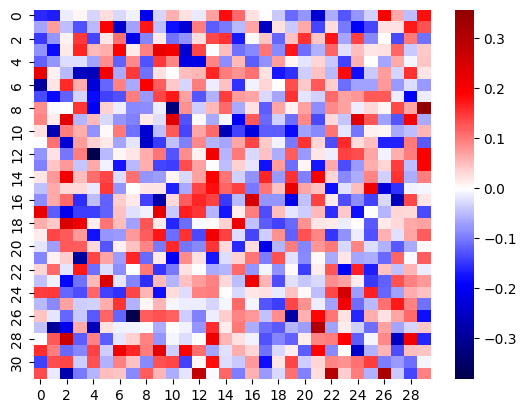

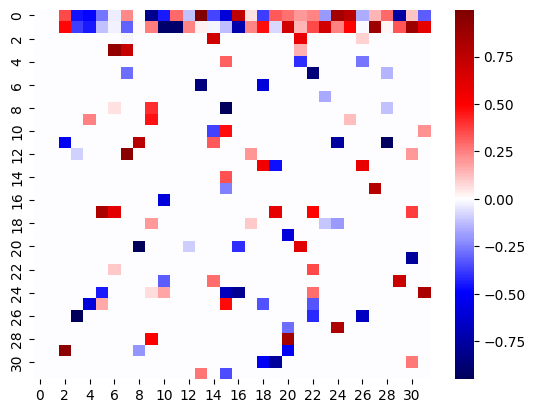

In [89]:
with torch.no_grad():
    for idx, data in enumerate(dataloader):

        optimizer.zero_grad()

        x = data.y[:,2:].to(device)
        x[:2] = (x[:2]+1)/2
        
        # scale the w_res
        #max_val = torch.max(x[2:])
        #min_val = torch.min(x[2:])
        #
        #x[2:] = x[2:]
        
        x_model = x.flatten()
        
        reconstruction, mu, log_var = model(x_model)
        
        arr = reconstruction.cpu().reshape(32,30)
        arr[:2] = arr[:2]*2 - 1
        sns.heatmap(arr,cmap='seismic',center=0)
        plt.show()
        sns.heatmap(data.y,cmap='seismic',center=0)
        plt.show()
        break

In [90]:
np.linspace(-2.7,2.7,100)

array([-2.7       , -2.64545455, -2.59090909, -2.53636364, -2.48181818,
       -2.42727273, -2.37272727, -2.31818182, -2.26363636, -2.20909091,
       -2.15454545, -2.1       , -2.04545455, -1.99090909, -1.93636364,
       -1.88181818, -1.82727273, -1.77272727, -1.71818182, -1.66363636,
       -1.60909091, -1.55454545, -1.5       , -1.44545455, -1.39090909,
       -1.33636364, -1.28181818, -1.22727273, -1.17272727, -1.11818182,
       -1.06363636, -1.00909091, -0.95454545, -0.9       , -0.84545455,
       -0.79090909, -0.73636364, -0.68181818, -0.62727273, -0.57272727,
       -0.51818182, -0.46363636, -0.40909091, -0.35454545, -0.3       ,
       -0.24545455, -0.19090909, -0.13636364, -0.08181818, -0.02727273,
        0.02727273,  0.08181818,  0.13636364,  0.19090909,  0.24545455,
        0.3       ,  0.35454545,  0.40909091,  0.46363636,  0.51818182,
        0.57272727,  0.62727273,  0.68181818,  0.73636364,  0.79090909,
        0.84545455,  0.9       ,  0.95454545,  1.00909091,  1.06